## Deep Learning Basic Model

In [1]:
import scipy.io
from pyedflib import highlevel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from itertools import groupby
#import csv
#import pickle
#from scipy.signal import butter, sosfilt, sosfiltfilt, sosfreqz
#from scipy.signal import freqz, iirnotch, filtfilt
from sklearn.preprocessing import MinMaxScaler
#from sklearn.base import TransformerMixin, BaseEstimator
#import random
#from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
import tensorflow as ts
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from plot_keras_history import show_history, plot_history

2022-12-01 17:23:12.938942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 17:23:13.236746: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-01 17:23:13.268433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-01 17:23:13.268451: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
sample_rate = 256
sec = 10
len_window = sample_rate*sec
overlap = 5

#### Data import

In [3]:
d5=pd.read_csv("/root/code/mariaaraujovitoria/SeizurePredict/raw_data/patient_5.csv",index_col = [0])
#d1=pd.read_csv("/root/code/mariaaraujovitoria/SeizurePredict/raw_data/patient_1.csv",index_col = [0])
#d2=pd.read_csv("/root/code/mariaaraujovitoria/SeizurePredict/raw_data/patient_2.csv",index_col = [0])
#d3=pd.read_csv("/root/code/mariaaraujovitoria/SeizurePredict/raw_data/patient_3.csv",index_col = [0])
#d6=pd.read_csv("/root/code/mariaaraujovitoria/SeizurePredict/raw_data/patient_6.csv",index_col = [0])


#### Preparation of windows and flattening

In [4]:
def flatten_window(window_df):
    if len(np.unique(window_df.iloc[:,-1])) == 1:
        target = window_df.iloc[0,-1]
    else:
        target = 1
    t_df = window_df.drop(columns = "is_seizure_target").transpose()
    flatten = pd.DataFrame(np.array(t_df).reshape(1,t_df.shape[0]*t_df.shape[1]))
    flatten["Target"] = target
    return flatten

def input_df_prep(df):
    df_ = np.array([flatten_window(df.iloc[i:i+len_window+1]) for i in range(0,len(df)-len_window, overlap*sample_rate)])

    r=df_.shape[0]
    c=df_.shape[2]
    df_=pd.DataFrame(df_.reshape(r,c))

    return df_


In [5]:
# Preparation of x and y, x_train and x_test, y_train and y_test

X = input_df_prep(d5).iloc[:,:-1]
y = input_df_prep(d5).iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [1]:
X_train.shape[1]

NameError: name 'X_train' is not defined

In [21]:

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(X_train, y_train)

#### First DL model on patient 5

Epoch 1/40
23/23 [==============================] - 4s 167ms/step - loss: 0.8387 - recall_8: 0.7519 - accuracy: 0.6080 - val_loss: 3.3427 - val_recall_8: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/40
23/23 [==============================] - 0s 13ms/step - loss: 0.5920 - recall_8: 0.9089 - accuracy: 0.6828 - val_loss: 0.9845 - val_recall_8: 0.0000e+00 - val_accuracy: 0.0710
Epoch 3/40
23/23 [==============================] - 0s 11ms/step - loss: 0.5146 - recall_8: 0.9399 - accuracy: 0.7382 - val_loss: 0.3469 - val_recall_8: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/40
23/23 [==============================] - 0s 11ms/step - loss: 0.4992 - recall_8: 0.9186 - accuracy: 0.7479 - val_loss: 0.5000 - val_recall_8: 0.0000e+00 - val_accuracy: 0.8774
Epoch 5/40
23/23 [==============================] - 0s 11ms/step - loss: 0.4052 - recall_8: 0.9787 - accuracy: 0.8296 - val_loss: 0.5665 - val_recall_8: 0.0000e+00 - val_accuracy: 0.7548
Epoch 6/40
23/23 [==============================] - 0s 11ms/

(<Figure size 1500x500 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot: title={'center': 'Recall'}, xlabel='Epochs', ylabel='Recall'>,
        <AxesSubplot: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

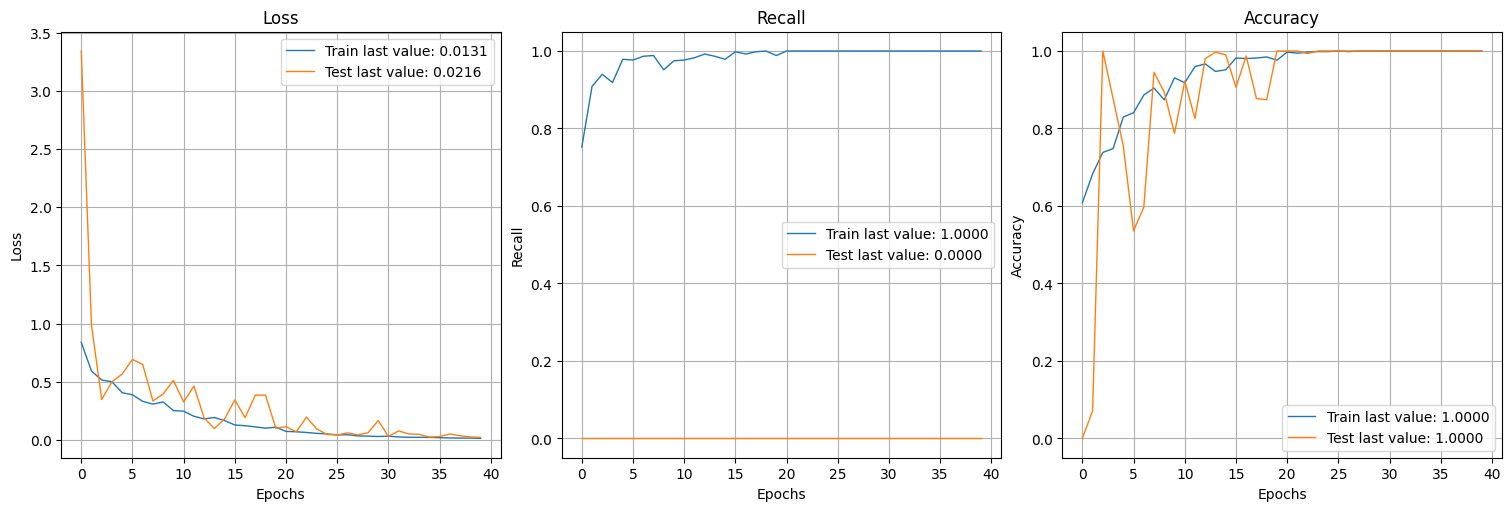

In [35]:

model = Sequential()
model.add(layers.Dense(20, activation='relu', input_dim=48659))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=[ts.keras.metrics.Recall(),"accuracy"])

history=model.fit(oversampled_trainX, oversampled_trainY,validation_split=0.3, batch_size=32, epochs=40)
plot_history(history)

In [36]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 4ms/step - loss: 0.6755 - recall_8: 0.9478 - accuracy: 0.8377


[0.6754656434059143, 0.9477611780166626, 0.8376623392105103]

#### Testing same model on patient 1

In [6]:
d1=pd.read_csv("/root/code/mariaaraujovitoria/SeizurePredict/raw_data/patient_1.csv",index_col = [0])

In [7]:
X_1 = input_df_prep(d1).iloc[:,:-1]
y_1 = input_df_prep(d1).iloc[:,-1]
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1,y_1, test_size=0.2)

In [8]:
# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX_1, oversampled_trainY_1 = sm.fit_resample(X_train_1, y_train_1)

In [7]:
oversampled_trainX_1.shape

(1680, 48659)

2022-12-01 17:27:43.770287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-01 17:27:43.775847: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-01 17:27:43.775959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-01 17:27:43.776318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-01 17:27:43.776391: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Epoch 1/100
37/37 [==============================] - 2s 43ms/step - loss: 1.6074 - recall: 0.3544 - accuracy: 0.6298 - val_loss: 0.3828 - val_recall: 0.8703 - val_accuracy: 0.8703
Epoch 2/100
37/37 [==============================] - 1s 16ms/step - loss: 0.7098 - recall: 0.3634 - accuracy: 0.7078 - val_loss: 0.2019 - val_recall: 0.9741 - val_accuracy: 0.9741
Epoch 3/100
37/37 [==============================] - 1s 16ms/step - loss: 0.5440 - recall: 0.4925 - accuracy: 0.7686 - val_loss: 0.9398 - val_recall: 0.3932 - val_accuracy: 0.3932
Epoch 4/100
37/37 [==============================] - 1s 17ms/step - loss: 0.6608 - recall: 0.5135 - accuracy: 0.7601 - val_loss: 0.6466 - val_recall: 0.6307 - val_accuracy: 0.6307
Epoch 5/100
37/37 [==============================] - 1s 18ms/step - loss: 0.6948 - recall: 0.5285 - accuracy: 0.7446 - val_loss: 6.0564 - val_recall: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/100
37/37 [==============================] - 1s 18ms/step - loss: 0.5050 - recall: 0

37/37 [==============================] - 1s 16ms/step - loss: 0.0029 - recall: 1.0000 - accuracy: 1.0000 - val_loss: 0.0041 - val_recall: 1.0000 - val_accuracy: 1.0000
Epoch 92/100
37/37 [==============================] - 1s 18ms/step - loss: 0.0027 - recall: 1.0000 - accuracy: 1.0000 - val_loss: 0.0031 - val_recall: 1.0000 - val_accuracy: 1.0000
Epoch 93/100
37/37 [==============================] - 1s 16ms/step - loss: 0.0026 - recall: 1.0000 - accuracy: 1.0000 - val_loss: 0.0038 - val_recall: 1.0000 - val_accuracy: 1.0000
Epoch 94/100
37/37 [==============================] - 1s 17ms/step - loss: 0.0025 - recall: 1.0000 - accuracy: 1.0000 - val_loss: 0.0049 - val_recall: 1.0000 - val_accuracy: 1.0000
Epoch 95/100
37/37 [==============================] - 1s 16ms/step - loss: 0.0024 - recall: 1.0000 - accuracy: 1.0000 - val_loss: 0.0035 - val_recall: 1.0000 - val_accuracy: 1.0000
Epoch 96/100
37/37 [==============================] - 1s 16ms/step - loss: 0.0024 - recall: 1.0000 - accurac

(<Figure size 1500x500 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot: title={'center': 'Recall'}, xlabel='Epochs', ylabel='Recall'>,
        <AxesSubplot: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

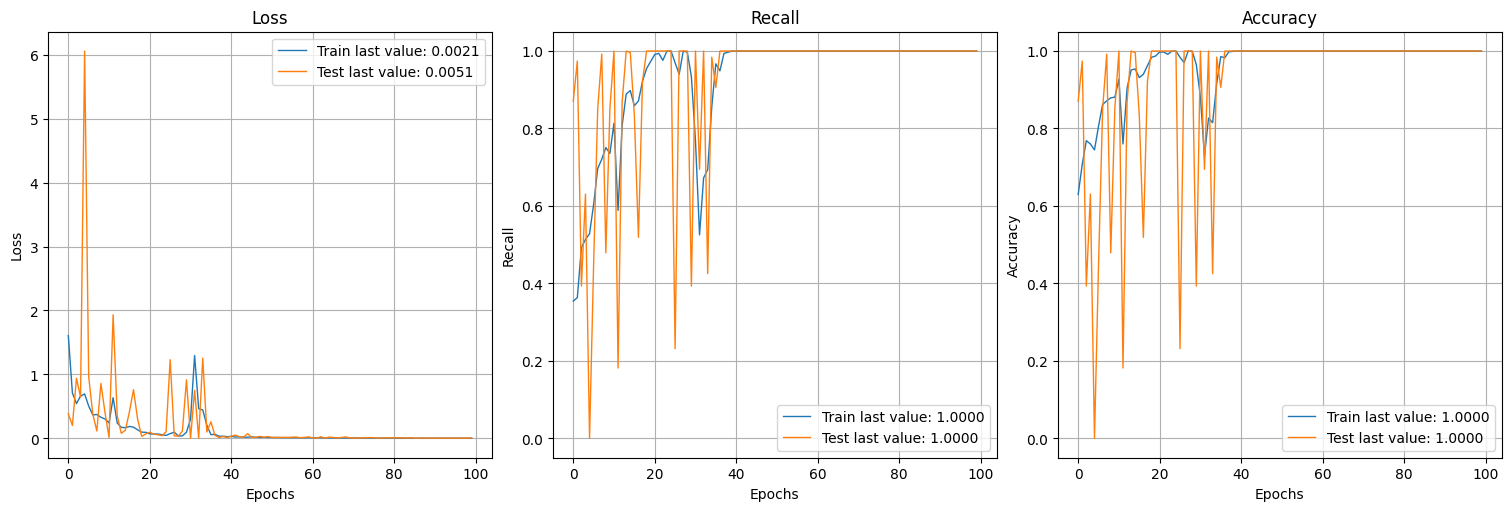

In [9]:
model_1 = Sequential()
model_1.add(layers.Dense(60, activation='relu', input_dim=48659))
model_1.add(layers.Dense(20, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=[ts.keras.metrics.Recall(),"accuracy"])

history_1=model_1.fit(oversampled_trainX_1, oversampled_trainY_1,validation_split=0.3, batch_size=32, epochs=100)
plot_history(history_1)

In [10]:
model_1.evaluate(X_train, y_train)

20/20 [==============================] - 0s 6ms/step - loss: 4.3270 - recall: 0.1496 - accuracy: 0.2659


[4.32697057723999, 0.14960630238056183, 0.26590538024902344]